### 2. Optimize the results

Since we get an accuracy of nearly 30% in the test set we try to improve the results by the following tecniques.

In [5]:
#Import the libraries
import keras as ks
from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

#import seaborn as sn
import pandas as pd
import tensorflow as tf
#from sklearn.metrics import classification_report, confusion_matrix
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import os
import glob
import numpy as np
import cv2 as cv2

In [6]:
import utility as ut
from buildDataSet import retrieve_from, reshape

We consider the train, validation and test set as of the previous task.

In [7]:
PATH_TRAIN=r'C:\Users\eleon\Documents\Uni_Trieste\DSSC_II_year_I_semester\Computer Vision\Exam\train'
PATH_TEST=r'C:\Users\eleon\Documents\Uni_Trieste\DSSC_II_year_I_semester\Computer Vision\Exam\test'

#array of the class
LABELS=[os.path.basename(i) for i in glob.glob(PATH_TRAIN + '/*', recursive=True)]
NUM_CLASSES = len(LABELS) 

X_train_raw, y_train_raw = retrieve_from(PATH_TRAIN, LABELS)
X_test, y_test = retrieve_from(PATH_TEST, LABELS)

# Resize the images in a proper dimension
X_train_raw = reshape(X_train_raw, width = 64, height = 64, channel = 1)
X_test = reshape(X_test, width = 64, height = 64, channel = 1)

# Use One-Hot Encoding to convert the labels into a set of numbers to input into the neural network.
y_train_one_hot = to_categorical(y_train_raw)
y_test_one_hot = to_categorical(y_test)

# Split the training set between train 85% and validation set 15%
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train_raw, y_train_one_hot, train_size=0.85, random_state=42)

#### Data augmentation

Given the small training set, data augmentation is likely to improve the performance. For the problem at hand,
left-to-right reflections are a reasonable augmentation technique.

In [8]:
data_generator = ImageDataGenerator(rotation_range=45,horizontal_flip=True)
train_aug = data_generator.flow(X_train, y_train, batch_size=32)

In [54]:
norm = ks.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
sgd = ks.optimizers.SGD(momentum=0.9,nesterov=True)

base_model = Sequential([
    Conv2D(8, 3,strides=1, padding='same',input_shape=(64,64,1)),
    Activation('relu'),
    MaxPooling2D(pool_size=2,strides=2),
    Conv2D(16, 3,strides=1, padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=2,strides=2),
    Conv2D(32, 3,strides=1, padding='same'),
    Activation('relu'),
    Flatten(),
    #set the initial bias values to 0
    Dense(NUM_CLASSES, activation='softmax',kernel_initializer=norm, bias_initializer='zeros')
])

base_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=5)

history_augmented=base_model.fit(
    train_aug,
    epochs=20,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

Epoch 1/20
40/40 [==============================] - 4s 96ms/step - loss: 2.7131 - accuracy: 0.0690 - val_loss: 2.7006 - val_accuracy: 0.1156

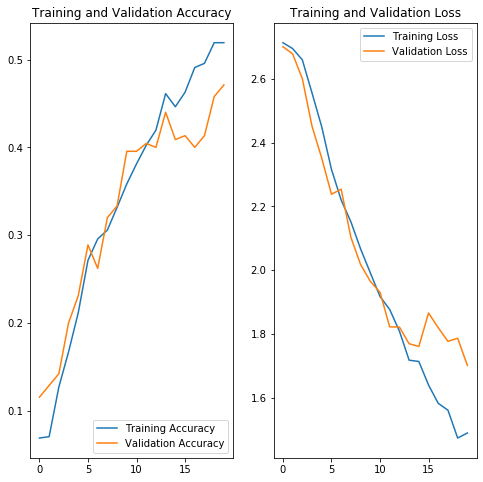

<Figure size 432x288 with 0 Axes>

In [55]:
ut.plot_acc_loss(history_augmented)
plt.savefig("accuracy and loss base model whit augmented data");

2985/2985 [==============================] - 3s 1ms/step

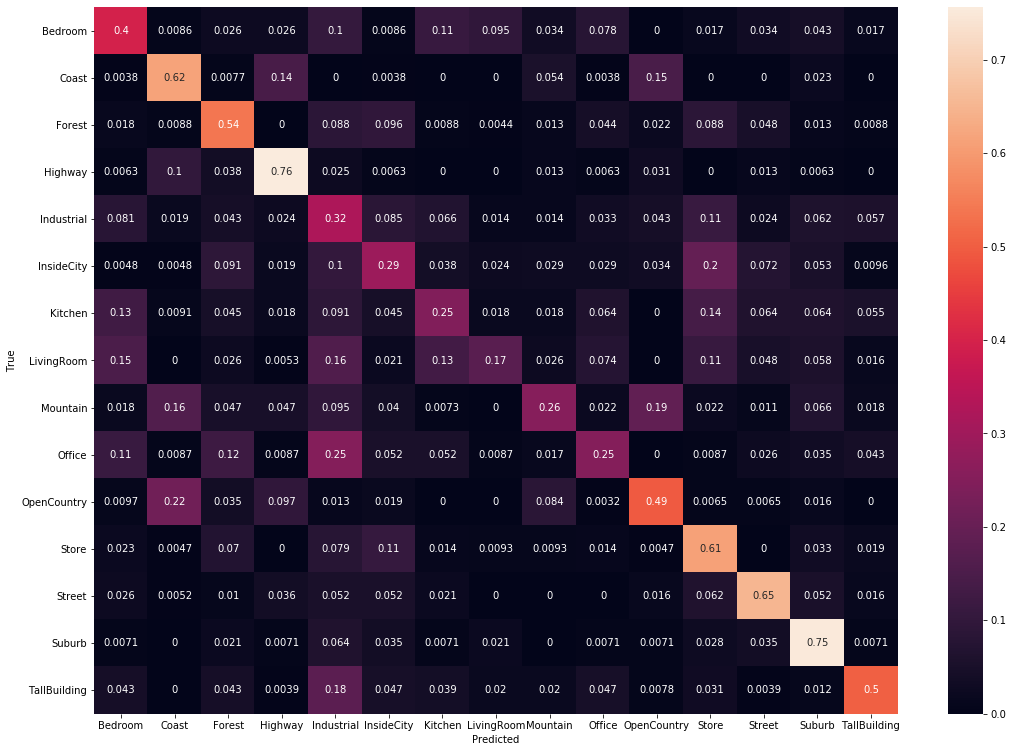

In [56]:
y_pred_aug = base_model.predict_classes(X_test)
loss0,accuracy0 = base_model.evaluate(X_test,y_test_one_hot)
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

ut.plot_confusion_matrix(y_test,y_pred_aug,LABELS)
plt.savefig("confusion matrix first model with data augmented");

#### Batch normalization

Add batch normalization layers before the reLU layers

In [22]:
norm_model = Sequential([
        Conv2D(8, 3,strides=1, padding='same',input_shape=(64,64,1)),
        BatchNormalization(axis=-1),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Conv2D(16, 3,strides=1, padding='same'),
        BatchNormalization(axis=-1),
        Activation('relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Conv2D(32, 3,strides=1, padding='same'),
        BatchNormalization(axis=-1),
        Activation('relu'),
        Flatten(),
        Dense(512,kernel_initializer=norm, bias_initializer='zeros'),
        Activation('relu'),
        Dense(NUM_CLASSES,kernel_initializer=norm, bias_initializer='zeros'),
        Activation('softmax')])

norm_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics = ['accuracy'])


In [26]:
es1 = EarlyStopping(monitor='val_loss', patience=10)

batch_sz=32
history_norm=norm_model.fit(
    X_train,
    y_train,
    batch_size=batch_sz,
    epochs=20,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es1]
)

Train on 1275 samples, validate on 225 samples
Epoch 1/20
1275/1275 [==============================] - 9s 7ms/step - loss: 0.0398 - accuracy: 0.9914 - val_loss: 3.5661 - val_accuracy: 0.2178

As we can see from the accuracy in the training set this model is probably affected by overfitting.

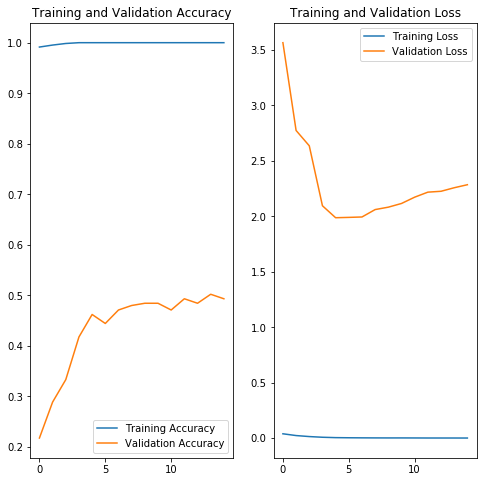

<Figure size 432x288 with 0 Axes>

In [27]:
ut.plot_acc_loss(history_norm)
plt.savefig("accuracy and loss model after adding batch normalization layers");

2985/2985 [==============================] - 5s 2ms/step

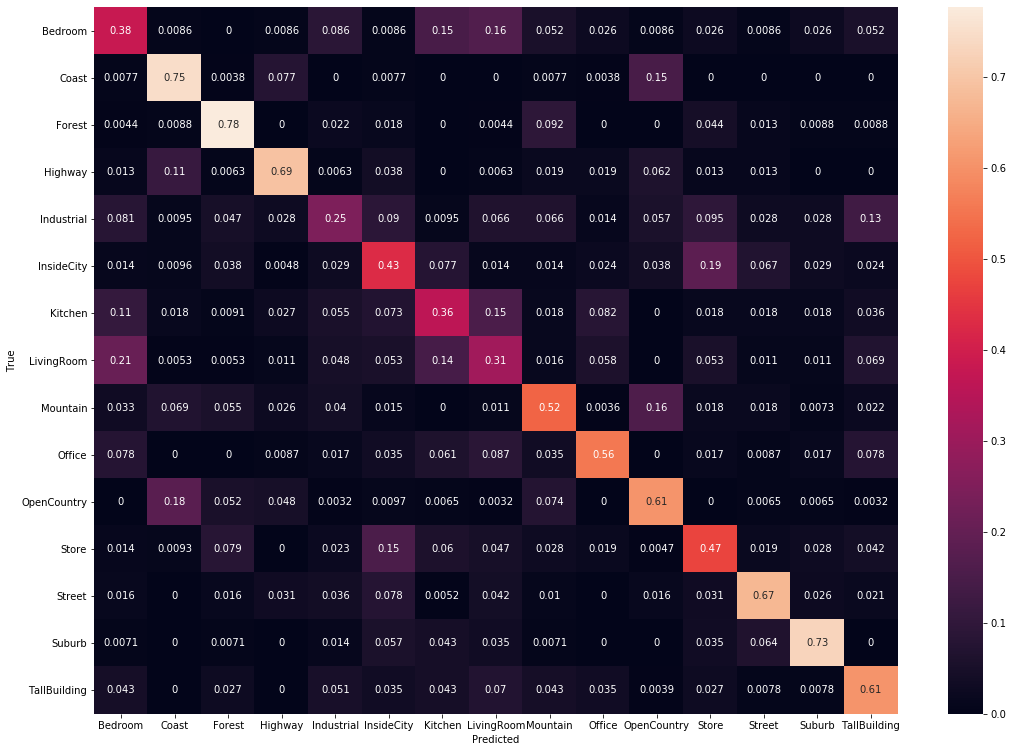

In [28]:
y_pred_norm = norm_model.predict_classes(X_test)
loss,accuracy = norm_model.evaluate(X_test,y_test_one_hot)
print("loss: {:.2f}".format(loss))
print("accuracy: {:.2f}".format(accuracy))

ut.plot_confusion_matrix(y_test,y_pred_norm,LABELS)
plt.savefig("confusion matrix second model");

We try train this model with the augmented data to reduce the overfitting.

In [32]:
history_norm_data_augmeted=norm_model.fit(
    train_aug,
    epochs=20,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

Epoch 1/20
40/40 [==============================] - 7s 178ms/step - loss: 2.6528 - accuracy: 0.2847 - val_loss: 6.1412 - val_accuracy: 0.1600

In [33]:
y_pred_norm_data_augmeted = norm_model.predict_classes(X_test)
loss,accuracy = norm_model.evaluate(X_test,y_test_one_hot)
print("loss: {:.2f}".format(loss))
print("accuracy: {:.2f}".format(accuracy))

2985/2985 [==============================] - 4s 1ms/step

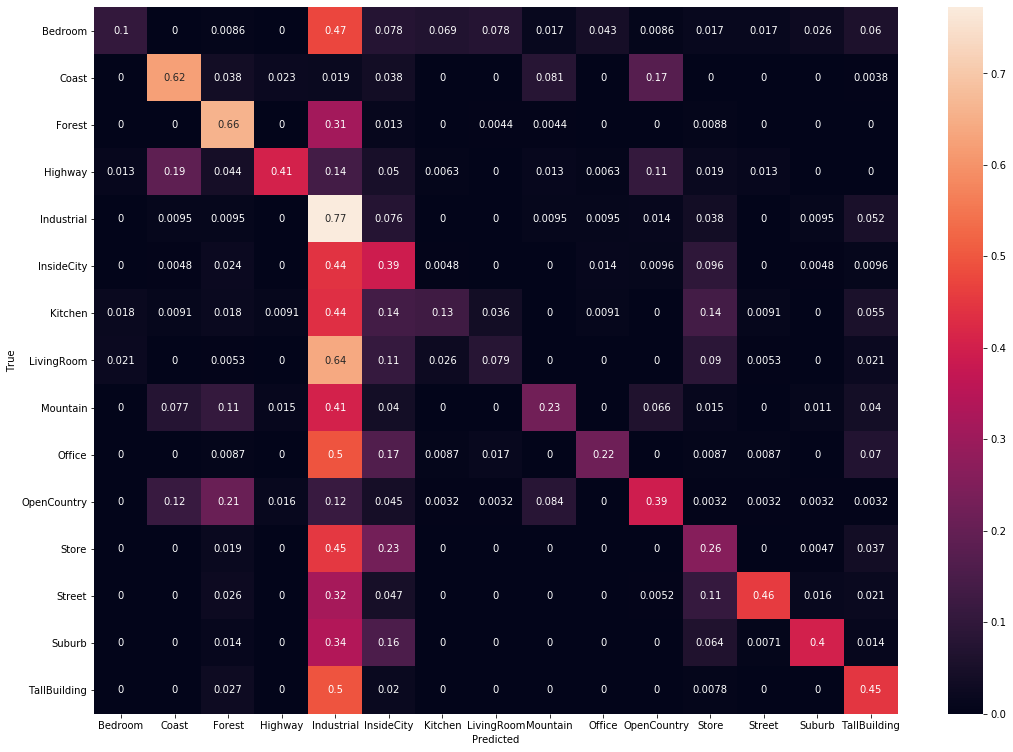

In [34]:
ut.plot_confusion_matrix(y_test,y_pred_norm_data_augmeted, LABELS)
plt.savefig("confusion matrix second model whit data augm");

As we can see the performance increases, so from now we will use data augmented to train our model.

#### Add and Resize convolutional filters

Increase the support of convolutional filters as we move from input to output:
3×3, 5×5, 7×7

In [35]:
model_res = Sequential([
    Conv2D(8, 3,strides=1, padding='same',input_shape=(64,64,1)),
    Activation('relu'),
    MaxPooling2D(pool_size=2,strides=2),
    Conv2D(16, 3,strides=1, padding='same'),
    Conv2D(16, 5,strides=1, padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=2,strides=2),
    Conv2D(32, 7,strides=1, padding='same'),
    Activation('relu'),
    Flatten(),
    Dense(NUM_CLASSES,kernel_initializer=norm, bias_initializer='zeros'),
    Activation('softmax')
    ])
model_res.compile(loss='categorical_crossentropy', optimizer=sgd, metrics = ['accuracy'])

In [36]:
history_res=model_res.fit(
    train_aug,
    epochs=30,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

Epoch 1/30
40/40 [==============================] - 8s 190ms/step - loss: 2.7085 - accuracy: 0.0580 - val_loss: 2.7054 - val_accuracy: 0.1022

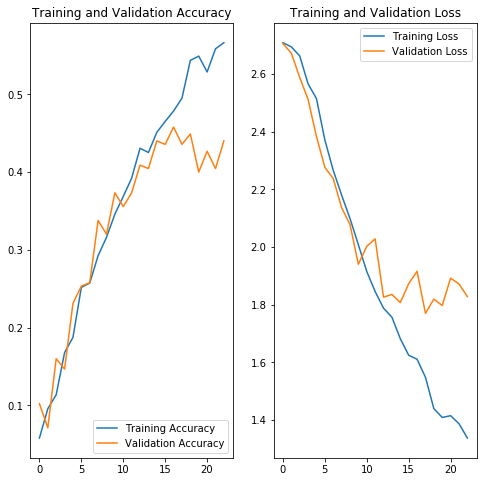

<Figure size 432x288 with 0 Axes>

In [37]:
ut.plot_acc_loss(history_res)
plt.savefig("accuracy and loss model after resizing layers");

2985/2985 [==============================] - 5s 2ms/step

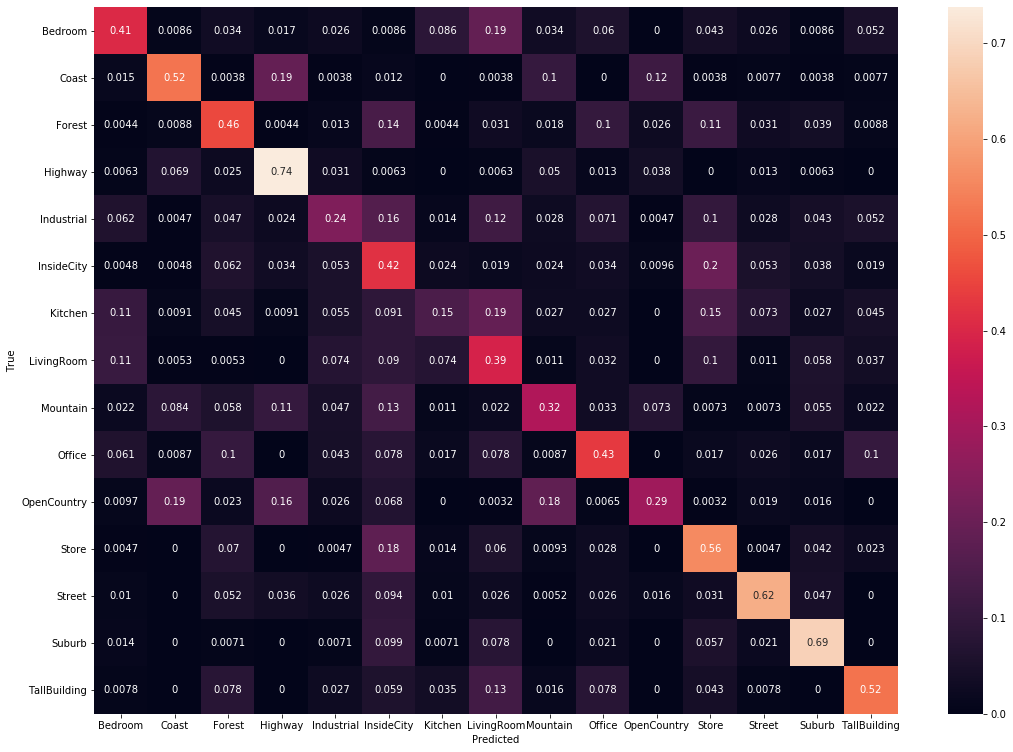

In [38]:
y_pred_res = model_res.predict_classes(X_test)
loss,accuracy = model_res.evaluate(X_test,y_test_one_hot)
print("loss: {:.2f}".format(loss))
print("accuracy: {:.2f}".format(accuracy))

ut.plot_confusion_matrix(y_test,y_pred_res, LABELS)
plt.savefig("confusion matrix third model");

As we can see this optimized tecnique seems not to bring improvements. Probably this is because small kernel can detects more relevant features. But considering the accurancy this model seems to be far from overfitting, for that reasons we add a batch normalization layer after the first convolutional layers.

We try to run normalize model with these kind of manipulation

In [39]:

model_res_norm = Sequential([
    Conv2D(8, 3,strides=1, padding='same',input_shape=(64,64,1)),
    BatchNormalization(axis=-1),
    Activation('relu'),
    MaxPooling2D(pool_size=2,strides=2),
    Conv2D(16, 3,strides=1, padding='same'),
    Conv2D(16, 5,strides=1, padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=2,strides=2),
    Conv2D(32, 7,strides=1, padding='same'),
    Activation('relu'),
    Flatten(),
    Dense(NUM_CLASSES,kernel_initializer=norm, bias_initializer='zeros'),
    Activation('softmax')
    ])
model_res_norm.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])


In [41]:
history_res_norm=model_res_norm.fit(
    train_aug,
    epochs=30,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

Epoch 1/30
40/40 [==============================] - 10s 251ms/step - loss: 2.6464 - accuracy: 0.1310 - val_loss: 3.0076 - val_accuracy: 0.0978

2985/2985 [==============================] - 6s 2ms/step

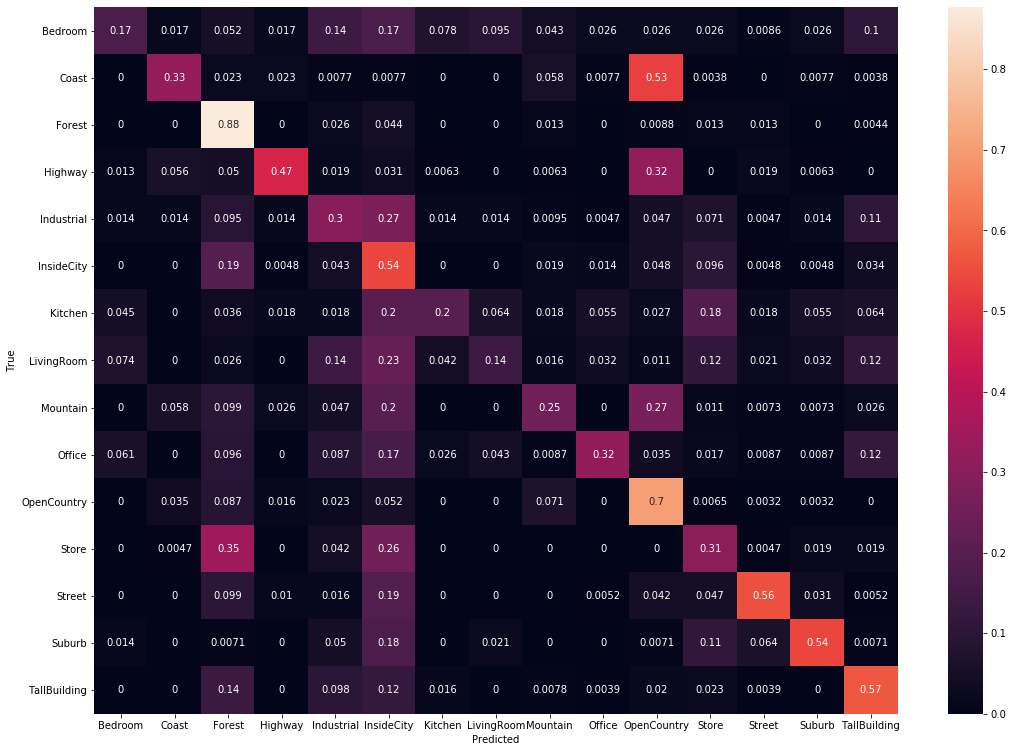

In [42]:
y_pred_res_norm = model_res_norm.predict_classes(X_test)
loss,accuracy = model_res_norm.evaluate(X_test,y_test_one_hot)
print("loss: {:.2f}".format(loss))
print("accuracy: {:.2f}".format(accuracy))

ut.plot_confusion_matrix(y_test,y_pred_res_norm, LABELS)
plt.savefig("confusion matrix fourth model");

#### Optimization parameter change

Weight regularization provides an approach to reduce the overfitting of a deep learning neural network model on the training data and improve the performance of the model on new data, such as the holdout test set.

There are multiple types of weight regularization, such as L1 and L2 vector norms, and each requires a hyperparameter that must be configured. In our case we add a l2 regularizer on layers.

In [43]:

model_opt_not_resized = Sequential([
    Conv2D(8, 3,strides=1, padding='same',input_shape=(64,64,1)),
    Activation('relu'),
    MaxPooling2D(pool_size=2,strides=2),
    Conv2D(16, 3,strides=1, padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=2,strides=2),
    Conv2D(32, 3,strides=1, padding='same'),
    Activation('relu'),
    Flatten(),
    Dense(NUM_CLASSES, activation='softmax',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))
])
#we switch to the Adam optimizer
model_opt_not_resized.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])


In [44]:
history_opt_not_resized=model_opt_not_resized.fit(
    train_aug,
    epochs=30,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

Epoch 1/30
40/40 [==============================] - 4s 92ms/step - loss: 2.8615 - accuracy: 0.0745 - val_loss: 2.7718 - val_accuracy: 0.1067

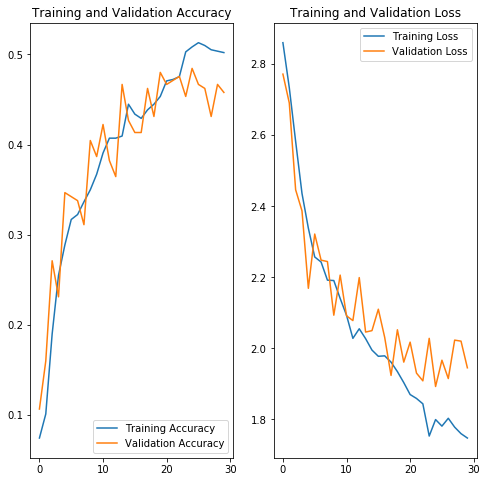

<Figure size 432x288 with 0 Axes>

In [45]:
ut.plot_acc_loss(history_opt_not_resized)
plt.savefig("accurancy and loss fifth model");

2985/2985 [==============================] - 3s 1ms/step

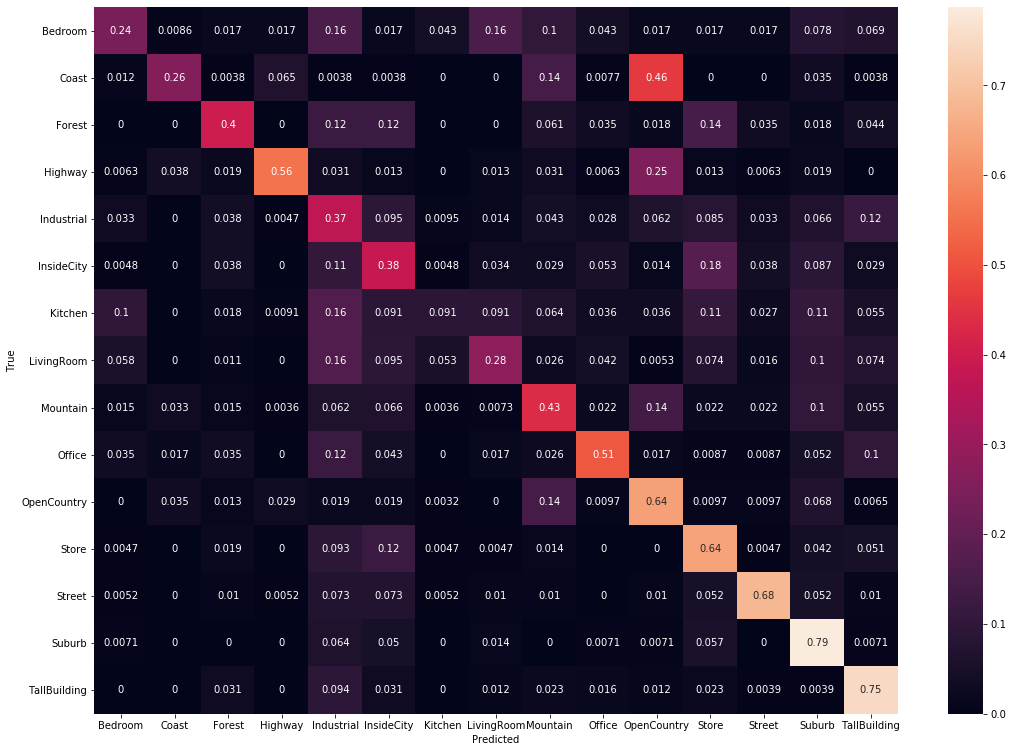

In [46]:
y_pred_opt_not_resized = model_opt_not_resized.predict_classes(X_test)
loss,accuracy = model_opt_not_resized.evaluate(X_test,y_test_one_hot)
print("loss: {:.2f}".format(loss))
print("accuracy: {:.2f}".format(accuracy))

ut.plot_confusion_matrix(y_test,y_pred_opt_not_resized, LABELS)
plt.savefig("confusion matrix fifth model");

We get a better accurancy but with a high loss and also our data seams to by affected by overfitting.

#### Dropout

We add some dropout layer to improve regularization. Introducing dropout layers to the network is a form of regularization that forces the weights in the network to take only small values, which makes the distribution of weight values more regular and the network can reduce overfitting on small training examples.

In [47]:
model_dr = Sequential([
    Conv2D(8, 3,strides=1, padding='same',input_shape=(64,64,1)),
    BatchNormalization(axis=-1),
    Activation('relu'),
    MaxPooling2D(pool_size=2,strides=2),
    Dropout(0.2),
    Conv2D(16, 3,strides=1, padding='same'),
    Conv2D(16, 5,strides=1, padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=2,strides=2),
    Dropout(0.2),
    Conv2D(32, 7,strides=1, padding='same'),
    Activation('relu'),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(NUM_CLASSES,kernel_initializer=norm, bias_initializer='zeros'),
    Activation('softmax')
])
model_dr.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])


In [48]:
history_dr=model_dr.fit(
    train_aug,
    epochs=30,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

Epoch 1/30
40/40 [==============================] - 14s 340ms/step - loss: 2.6706 - accuracy: 0.1004 - val_loss: 2.6551 - val_accuracy: 0.1244

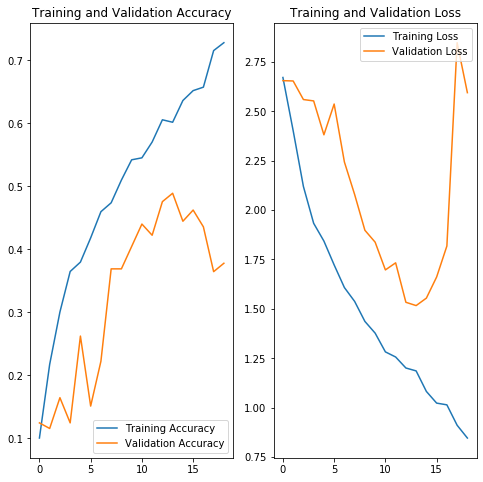

<Figure size 432x288 with 0 Axes>

In [49]:
ut.plot_acc_loss(history_dr)
plt.savefig("accurancy and loss model after dropout");

2985/2985 [==============================] - 8s 3ms/step

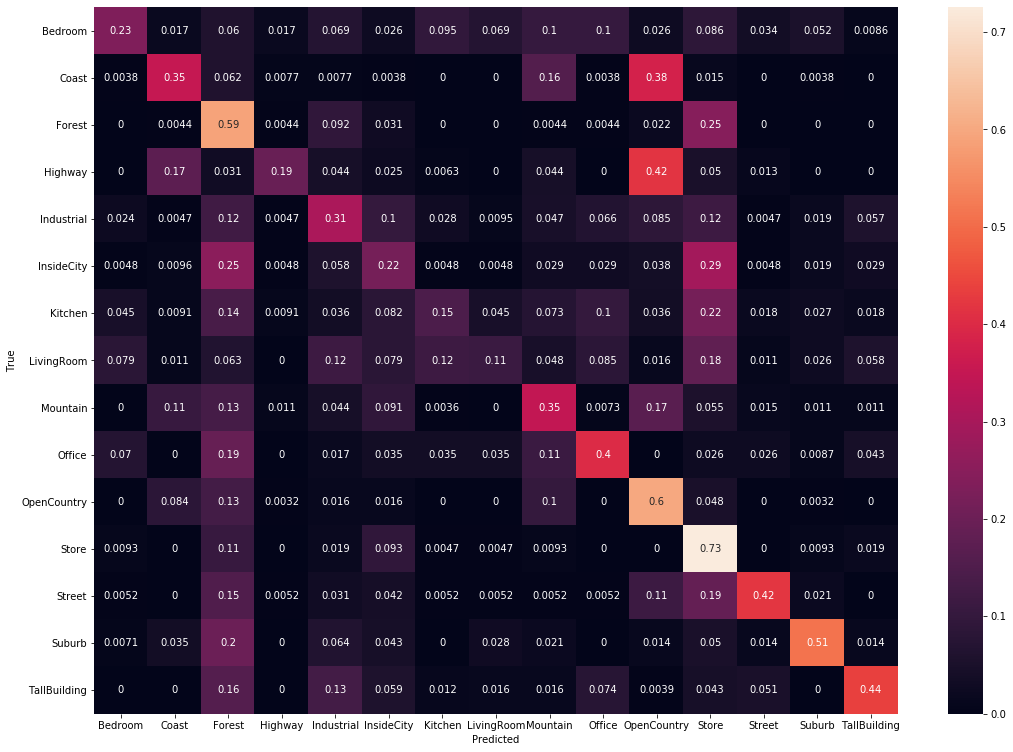

In [50]:
y_pred_dr = model_dr.predict_classes(X_test)
loss,accuracy = model_dr.evaluate(X_test,y_test_one_hot)
print("loss: {:.2f}".format(loss))
print("accuracy: {:.2f}".format(accuracy))

ut.plot_confusion_matrix(y_test,y_pred_dr, LABELS)
plt.savefig("confusion matrix sixth model");

I try to write a model combining all the tecniques.

In [51]:
model_dr_mod = Sequential([
    Conv2D(8, 3,strides=1, padding='same',input_shape=(64,64,1)),
    BatchNormalization(axis=-1),
    Activation('relu'),
    MaxPooling2D(pool_size=2,strides=2),
    Dropout(0.2),
    Conv2D(16, 3,strides=1, padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=2,strides=2),
    Conv2D(32, 5,strides=1, padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=2,strides=2),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(NUM_CLASSES,kernel_initializer=norm, bias_initializer='zeros'),
    Activation('softmax')
])
model_dr_mod.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])


In [52]:
history_dr_mod=model_dr_mod.fit(
    train_aug,
    epochs=30,
    validation_data=(X_validation,y_validation),
    shuffle=True,
    callbacks=[es]
)

Epoch 1/30
40/40 [==============================] - 9s 226ms/step - loss: 2.7054 - accuracy: 0.0918 - val_loss: 2.7019 - val_accuracy: 0.0667

2985/2985 [==============================] - 5s 2ms/step

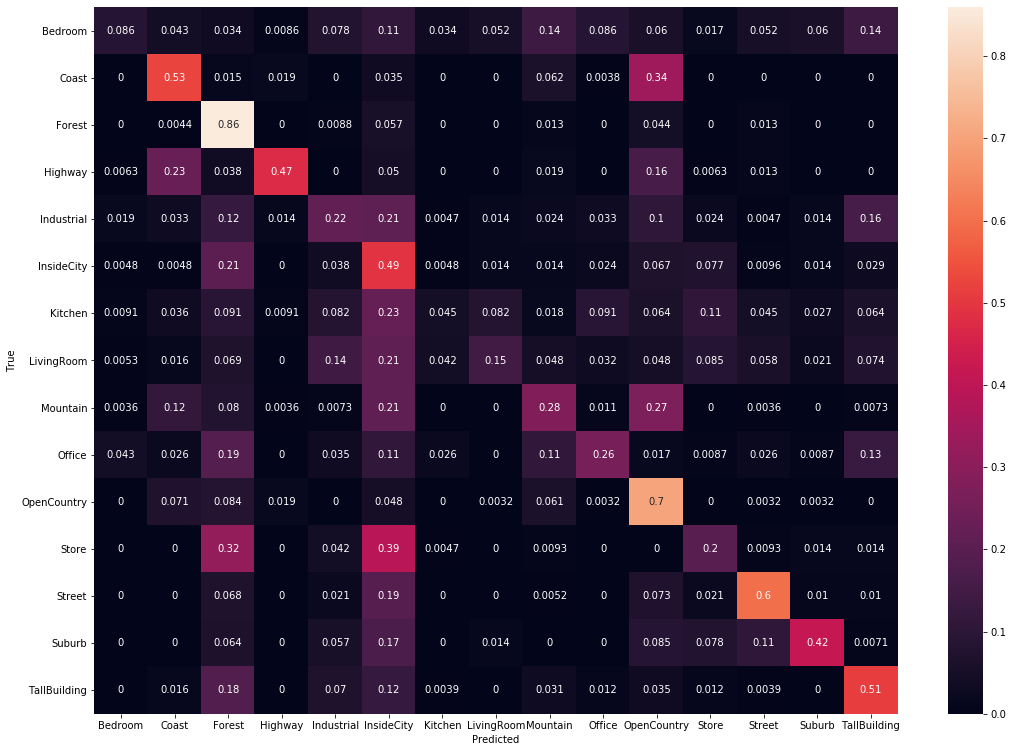

In [53]:
y_pred_dr_mod = model_dr_mod.predict_classes(X_test)
loss,accuracy = model_dr_mod.evaluate(X_test,y_test_one_hot)
print("loss: {:.2f}".format(loss))
print("accuracy: {:.2f}".format(accuracy))

ut.plot_confusion_matrix(y_test,y_pred_dr_mod,LABELS)
plt.savefig("confusion matrix seventh model");

Combining the tecniques we get one of the best score.

#### Ensemble of networks

The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses. So we try to combine our previously models.

In [57]:
final_prediction = [y_pred_aug, y_pred_norm, y_pred_norm_data_augmeted, y_pred_res, y_pred_res_norm, y_pred_opt_not_resized, y_pred_dr, y_pred_dr_mod]
NUM_MODELS=8
    
# Ensemble with voting
final_prediction = np.array(final_prediction)
final_prediction = np.transpose(final_prediction)
final_prediction = scipy.stats.mode(final_prediction,axis=1)[0]


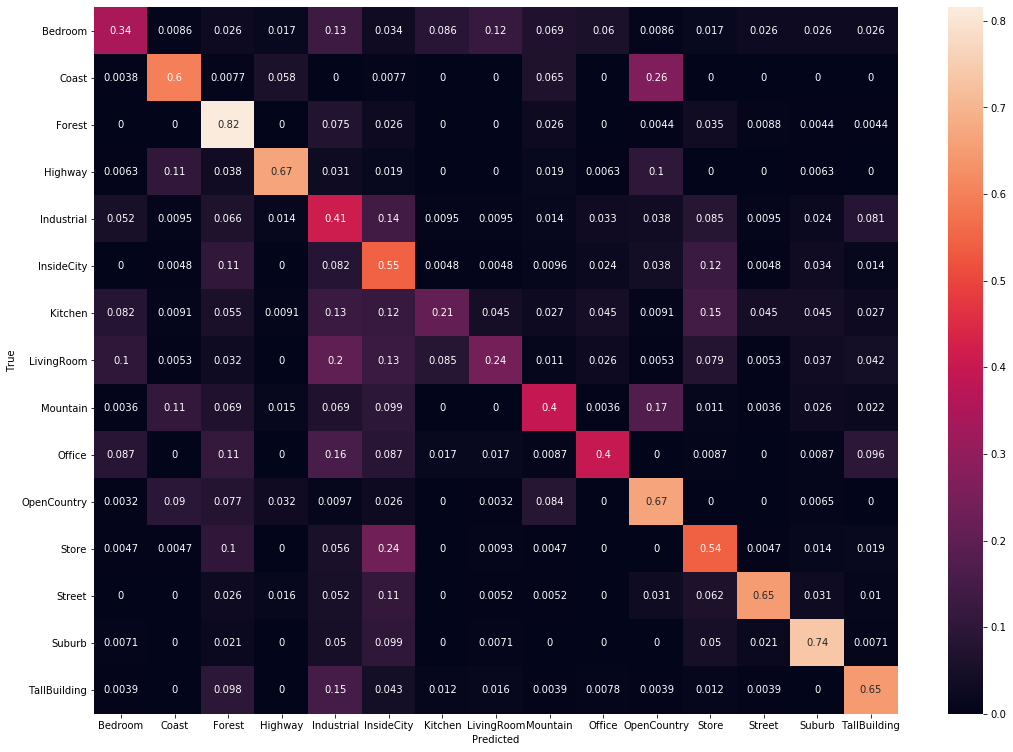

In [59]:
ut.plot_confusion_matrix(y_test,final_prediction, LABELS)
plt.savefig("confusion matrix ensamble of networks model");

In [60]:
from sklearn.metrics import classification_report
print('Classification Report')
print(classification_report(y_test, final_prediction, target_names=LABELS))


Classification Report
              precision    recall  f1-score   support

     Bedroom       0.42      0.34      0.38       116
       Coast       0.65      0.60      0.62       260
      Forest       0.52      0.82      0.64       228
     Highway       0.74      0.67      0.70       160
  Industrial       0.29      0.41      0.34       211
  InsideCity       0.34      0.55      0.42       208
     Kitchen       0.40      0.21      0.28       110
  LivingRoom       0.58      0.24      0.34       189
    Mountain       0.60      0.40      0.48       274
      Office       0.58      0.40      0.47       115
 OpenCountry       0.57      0.67      0.61       310
       Store       0.51      0.54      0.53       215
      Street       0.86      0.65      0.74       192
      Suburb       0.68      0.74      0.71       141
TallBuilding       0.74      0.65      0.69       256

    accuracy                           0.55      2985
   macro avg       0.57      0.53      0.53      2985
weig